In [1]:
# HASTA AQUI REALIZAMOS UNA PEQUENA APROXIMACION, USANDO SPEP, EN ESTA SIMULACION USAREMOS SPEMD

## SEGUNDA APROXIMACION AL LENTE DE QUADMODEL DEL RUNG0
# Llamamos todas las librerias que se usan en Lenstronomy, tomandolas de los rung anteriores
# para esta simulacion haremos un pequeño procesamiento a las imagenes sumistradas, trataremos
# de quitar el ruido


## LLAMANDO LIBRERIAS DE LENSTRONOMY
import numpy as np                                  # Libreria numerica, definimos numeros
import time                                         # Libreria de simulacion.
import corner
import matplotlib.pyplot as plt
import matplotlib
import os
import copy
import astropy.io.fits as pyfits
import astropy
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Plots.output_plots as lens_plot
import matplotlib.pyplot as plt
%matplotlib inline

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from lenstronomy.Util import constants

import lenstronomy.Util.param_util as param_util

from lenstronomy.ImSim.image_model import ImageModel

from lenstronomy.PointSource.point_source import PointSource

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

from lenstronomy.LightModel.light_model import LightModel

from lenstronomy.Sampling.parameters import Param

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

from lenstronomy.Cosmo.lens_cosmo import LensCosmo

from astropy.cosmology import FlatLambdaCDM

from astropy.io import fits

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

In [2]:
## Definimos condiciones COSMOLOGICAS Y OBSERVACIONALES.

# Condiciones observacionales, estas librerias nos determinan condiciones para simulacion de imagenes
background_rms = .05  # background noise per pixel
exp_time = 1200  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 99  # cutout pixel size
#delta pix parametro a utilizar por el PSF creemos que se relaciona con el brillo
deltaPix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF
psf_type = 'PIXEL'
kernel_size = 99

# Condiciones cosmologicas, distancias de la lente y del medio
z_lens = 0.858
z_source = 2.175

# Tipo de cosmologia a utilizar, esto es importante para la reconstruccion de la lente en masa

#cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)
#lensCosmo = LensCosmo(cosmo=cosmo, z_lens=z_lens, z_source=z_source)

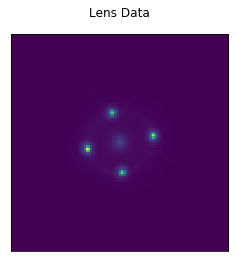

In [3]:
# SUBIMOS LOS DATOS
# Definimos entradas de las imagenes. inicialmente solo usaremos lens-image.fits
# Note que debemos subir los psf en otra seccion.
#fits_image_filename = fits.util.get_testdata_filepath('lens-image.fits')
#fits_noise_filename = fits.util.get_testdata_filepath('noise_map.fits')
path = 'rung0/code1/f160w-seed3/drizzled_image/'

# Abrimos imagenes las definimos como matrices
#hdul = fits.open('lens-image.fits')
hdullens = fits.open(path+'lens-image.fits')
hdulnoise = fits.open(path+'noise_map.fits')
hdulpsf = fits.open(path+'psf.fits')

#image_data = hdul[0].data 
lens_data = hdullens[0].data
noise_data = hdulnoise[0].data
psf_data = hdulpsf[0].data

f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(lens_data, origin='lower')
ax.set_title("Lens Data")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

/home/hiparco/anaconda3/envs/lenstronomy/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


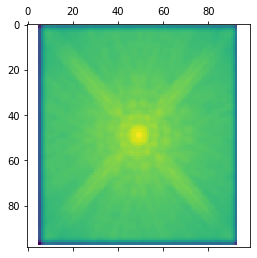

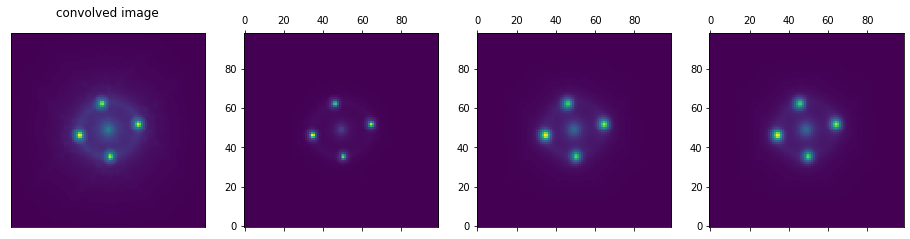

In [4]:
# PROCESAMIENTO DE LOS DATOS, CONVOLUCION CON RESPECTO AL PSF Y SUMA DEL RUIDO
# Es necesario sumar el ruido ya que este es el encargado de la formacion de la luz en el medio, por eso en Rung006 no estaba 
# El anillo de Einstein

# IMPORTANTE EL PREPROCESAMIENTO DEBE TENER CONVOLUCION CON EL PSF PARA PODER SUBIRLO AL IMAGE DATA.

# Definiendo librerias importante
# we define a very high resolution grid for the ray-tracing (needs to be checked to be accurate enough!)
numPix = 99  # number of pixels (low res of data)
deltaPix = 0.08  # pixel size (low res of data)

# Importando PSF

kernel = psf_data.copy()
plt.matshow(np.log10(kernel))

# and now we perform the convolution with the scipy built in routine fftconvolve
import scipy.signal as signal
image_convolved = signal.fftconvolve(lens_data, kernel, mode='same')
image_convolved_bak = image_convolved.copy()

f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(16, 4), sharex=False, sharey=False)
im = ax1.matshow(noise_data, origin='lower')
im = ax2.matshow(lens_data, origin='lower')
im = ax3.matshow(image_convolved, origin='lower')
im = ax4.matshow(image_convolved+ noise_data, origin='lower')
ax1.set_title("convolved image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.autoscale(False)


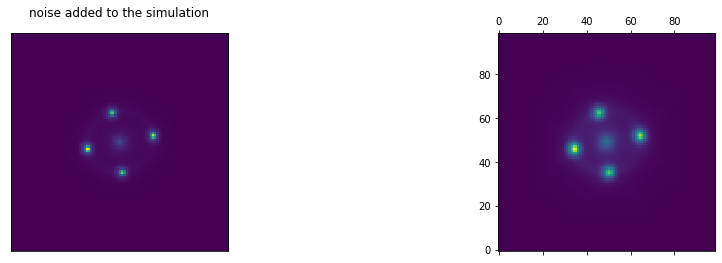

/home/hiparco/anaconda3/envs/lenstronomy/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log10


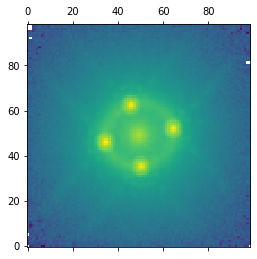

In [5]:
# PROCESAMIENTO DEL RUIDO DE LA IMAGEN, LA PARTE DE LA PIXELISACION PUEDE NO SER NECESARIA.

# and we add here another Gaussian component uniform over the entire image (just because it's easy)
background_rms = 10  # background rms
bkg = image_util.add_background(image_convolved, sigma_bkd=noise_data)

# and we add them all together
#image_data = image_convolved + bkg
image_data = lens_data+bkg

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 4), sharex=False, sharey=False)
im = ax1.matshow(image_data, origin='lower')
im = ax2.matshow(image_convolved, origin='lower')
ax1.set_title("noise added to the simulation")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.autoscale(False)
plt.show()

# Amabas imagenes para comparativo
plt.matshow(np.log10(image_data), origin='lower')
plt.show()


In [6]:
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, noise_data)
print(kwargs_data)

{'background_rms': array([[0.00255352, 0.00255848, 0.00257077, ..., 0.00256791, 0.00256774,
        0.00256968],
       [0.00255884, 0.00256529, 0.00257709, ..., 0.00257353, 0.0025715 ,
        0.0025716 ],
       [0.00257274, 0.00257866, 0.00259088, ..., 0.00258607, 0.00258145,
        0.00258049],
       ...,
       [0.00257454, 0.00258023, 0.0025925 , ..., 0.00258952, 0.00258415,
        0.00258302],
       [0.00257455, 0.00257844, 0.0025882 , ..., 0.00258489, 0.00257976,
        0.00257917],
       [0.00257665, 0.00257861, 0.00258729, ..., 0.00258387, 0.00257921,
        0.00257891]], dtype=float32), 'exposure_time': array([[1200., 1200., 1200., ..., 1200., 1200., 1200.],
       [1200., 1200., 1200., ..., 1200., 1200., 1200.],
       [1200., 1200., 1200., ..., 1200., 1200., 1200.],
       ...,
       [1200., 1200., 1200., ..., 1200., 1200., 1200.],
       [1200., 1200., 1200., ..., 1200., 1200., 1200.],
       [1200., 1200., 1200., ..., 1200., 1200., 1200.]]), 'ra_at_xy_0': -3.92, 

{'background_rms': 1, 'exposure_time': array([[1200., 1200., 1200., ..., 1200., 1200., 1200.],
       [1200., 1200., 1200., ..., 1200., 1200., 1200.],
       [1200., 1200., 1200., ..., 1200., 1200., 1200.],
       ...,
       [1200., 1200., 1200., ..., 1200., 1200., 1200.],
       [1200., 1200., 1200., ..., 1200., 1200., 1200.],
       [1200., 1200., 1200., ..., 1200., 1200., 1200.]]), 'ra_at_xy_0': -3.92, 'dec_at_xy_0': -3.92, 'transform_pix2angle': array([[0.08, 0.  ],
       [0.  , 0.08]]), 'image_data': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}


/home/hiparco/anaconda3/envs/lenstronomy/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log10


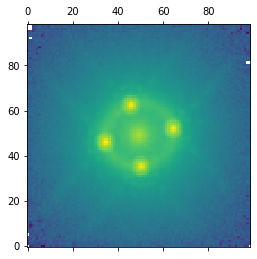

IMAGEN FINAL


In [7]:
# Restringiendo subsecciones de ruido
# Preprocesamiento basico
# Operacion que busca apaciguar un poco de ruido
#image_data = lens_data*noise_data

# librerias data de imagen y ruido
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time)
print(kwargs_data)
data_class = ImageData(**kwargs_data)

# librerias data de psf, son diferentes para psf como para imagenes.
#kwargs_psf = {'psf_type': PIXEL, 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 8}
#psf_class = PSF(**kwargs_psf)
#kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
#psf_class = PSF(**kwargs_psf)

kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': kernel}
psf_class = PSF(**kwargs_psf)


# subimos las imagenes mediante la rutina update date, de imaging data.
data_class.update_data(image_data)
kwargs_data['image_data'] = image_data

#data_class.update_data(lens_data)
#kwargs_data['lens_data'] = lens_data

#data_class.update_data(noise_data)
#kwargs_data['noise_map'] = noise_data

#data_class.update_data(psf_data)
#kwargs_psf['psf'] = psf_filename

# para corroborar que si subimos las imagenes, las imprimimos
plt.matshow(np.log10(data_class.data), origin='lower')
plt.show()
print('IMAGEN FINAL')

#plt.matshow(np.log10(lens_data), origin='lower')
#plt.show()

#plt.matshow(np.log10(noise_data), origin='lower')
#plt.show()

#plt.matshow(np.log10(psf_data), origin='lower')
#plt.show()

In [8]:
## DFINICION DE VALORES INCICIALES
from numpy import array

# valores iniciales obtenidos por RUNG006 pueden ser de utilidad en esta seccion.
# Esta sección es una unificación entre lo valores que se obtuvieron por EXCEL y los valores iniciales
# de la simulación, inicialmente restringimos valores a los aproximados de EXCEL.

# Con la ayuda de IRAF deterinamos la ubicacion en pixeles, sabiendo que cada pixel son 0.08" para drizzzle images
# el centro esta ubicado en pixeles x = 49.919 y = 50.002
x_A = 0.08480
x_B = -1.16496
x_C = 1.21336
x_D = -0.27544

y_A = -1.09936
y_B = -0.24800
y_C = 0.22269
y_D = 1.05784

# Definimos valor de Anillo de Einstein Inicial
theta_E = 1.155297871

# Definimos ubicacion de las imagenes en la lente.
x_list = [x_A, x_B, x_C, x_D]
y_list = [y_A, y_B, y_C, y_D]

# Transformando los datos en legibles Lenstronomy.
x_image = array(x_list)
y_image = array(y_list)

print(x_image)
print(y_image)
type(x_image)

#Agregamos la opcion de determinar el centro con rayshooting.


[ 0.0848  -1.16496  1.21336 -0.27544]
[-1.09936 -0.248    0.22269  1.05784]


numpy.ndarray

In [9]:
# CAMBIO MAS SIGNIFICATIVO ENTRE EL RUNG006, VAMOS A MODIFICAR EL TIPO DE LENTE A COMPILAR POR SPEMD 
# Definimos condiciones de simulacion de la lente.

# Definimos el tipo de modelo de lente que necesitamos, lens_model_list
# para esta primera simulacion escogemos SPEMD Y SHEAR, esto debido a que ya conocemos los resultados.
lens_model_list = ['SPEMD','SHEAR_GAMMA_PSI']
# definimos tambien la clase
lens_model_class = LensModel(lens_model_list=lens_model_list)

# Definimos modelo de luz de la fuente SOURCE AGN, tenemos la opcion de puntual, sersic y sersic ellipse
source_model_list = ['SERSIC_ELLIPSE']

# Definimos modelo de luz de la lente, LENS, es una galaxia no activa. Sabemos que es Elliptica debido a las
# respuestas del RUNG-0
lens_light_model_list = ['SERSIC_ELLIPSE']

# Usamos la libreria point source Desconocemos su utilidad, podemos inicialmente obviarlo
# Debemos solucionar la ecacion de lente para encontrar las ubicaciones de las imagenes en el 
# plano de la lente, sin embargo las ubicaciones ya la determinamos
point_source_list = ['LENSED_POSITION']

kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list,
                'point_source_model_list': point_source_list,
                'additional_images_list': [False],
                'fixed_magnification_list': [False],
                             }
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                              'num_point_source_list': [4],
                              'solver_type': 'PROFILE',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                              }

kwargs_likelihood = {'check_bounds': True,
                             'force_no_add_image': False,
                             'source_marg': False,
                             'position_uncertainty': 0.004,
                             'check_solver': True,
                             'solver_tolerance': 0.001
                             }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

print(x_image)
print(y_image)

[ 0.0848  -1.16496  1.21336 -0.27544]
[-1.09936 -0.248    0.22269  1.05784]


In [10]:
################# SIMULACION HARDCORE #####################
# En erste punto habiendo definido mis condiciones iniciales corremos simulacion
# initial guess of non-linear parameters, we chose different starting parameters than the truth #


# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init = [{'theta_E': 1.2, 'e1': 0, 'e2': 0, 'gamma': 2., 'center_x': 0., 'center_y': 0},
    {'gamma_ext': 0.01, 'psi_ext': 0.}]
kwargs_source_init = [{'R_sersic': 0.03, 'n_sersic': 1., 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_lens_light_init = [{'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_ps_init = [{'ra_image': x_image+0.01, 'dec_image': y_image-0.01}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2, 'gamma': .2, 'center_x': 0.1, 'center_y': 0.1},
    {'gamma_ext': 0.1, 'psi_ext': np.pi}]
kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2}]
kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': 0.1}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 4, 'dec_image': [0.02] * 4}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10., 'center_y': -10},
    {'gamma_ext': 0., 'psi_ext': -np.pi}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image), 'dec_image': -10 * np.ones_like(y_image)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10., 'center_y': 10},
    {'gamma_ext': 0.3, 'psi_ext': np.pi}]
kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image), 'dec_image': 10 * np.ones_like(y_image)}]

lens_params = [kwargs_lens_init, kwargs_lens_sigma, [{}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, [{}], kwargs_lower_lens_light, kwargs_upper_lens_light]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 40}],
                       ['MCMC', {'n_burn': 50, 'n_run': 5, 'walkerRatio': 2, 'sigma_scale': .01}]
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

/home/hiparco/anaconda3/envs/lenstronomy/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Computing the PSO ...
10
20
30
40
max iteration reached! stoping
-0.012956539525780691 reduced X^2 of best position
-63.31860866249024 logL
9774 effective number of data points
[{'theta_E': 1.1565394684094177, 'gamma': 1.6797191440718473, 'e1': 0.09387115244765923, 'e2': 0.04511413515843658, 'center_x': 0.01637366613567135, 'center_y': 0.000319410747961966}, {'gamma_ext': 0.08789589137097688, 'psi_ext': 0.22120926393923934, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.4815341157234907, 'n_sersic': 1.8216915320071347, 'e1': -0.009159688460891227, 'e2': -0.08445576986446576, 'center_x': 0.016483856391582254, 'center_y': -0.00012184071962538512}] source result
[{'amp': 1, 'R_sersic': 0.42577780558579503, 'n_sersic': 2.0884505708760237, 'e1': 0.05242320405001431, 'e2': 0.026095934817970835, 'center_x': 0.003937456221392277, 'center_y': 0.012971869455779087}] lens light result
[{'ra_image': array([ 0.08425866, -1.16845731,  1.21078395, -0.27748057]), 'dec_image': array([-1.

/home/hiparco/anaconda3/envs/lenstronomy/lib/python3.7/site-packages/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,


Computing the MCMC...
Number of walkers =  42
Burn-in iterations:  50
Sampling iterations: 5
43.26817202568054 time taken for MCMC sampling


-0.012920846579428678 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.012929976148213548
(21, ['gamma_lens0', 'gamma_ext_lens1', 'psi_ext_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image'])


/home/hiparco/anaconda3/envs/lenstronomy/lib/python3.7/site-packages/lenstronomy/Plots/output_plots.py:546: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


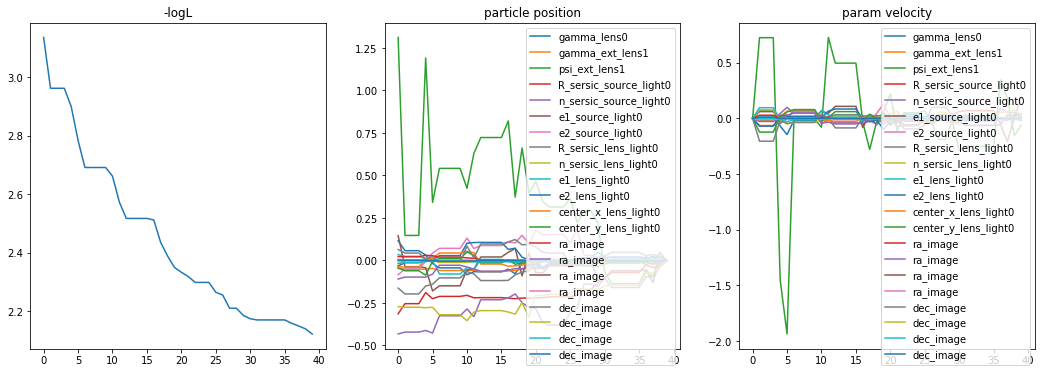

<Figure size 432x288 with 0 Axes>

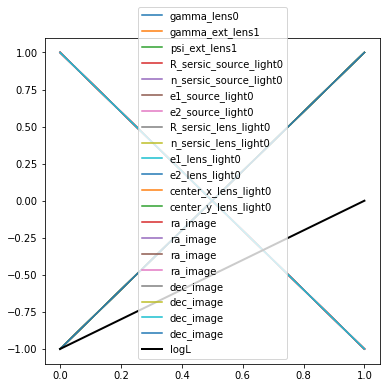

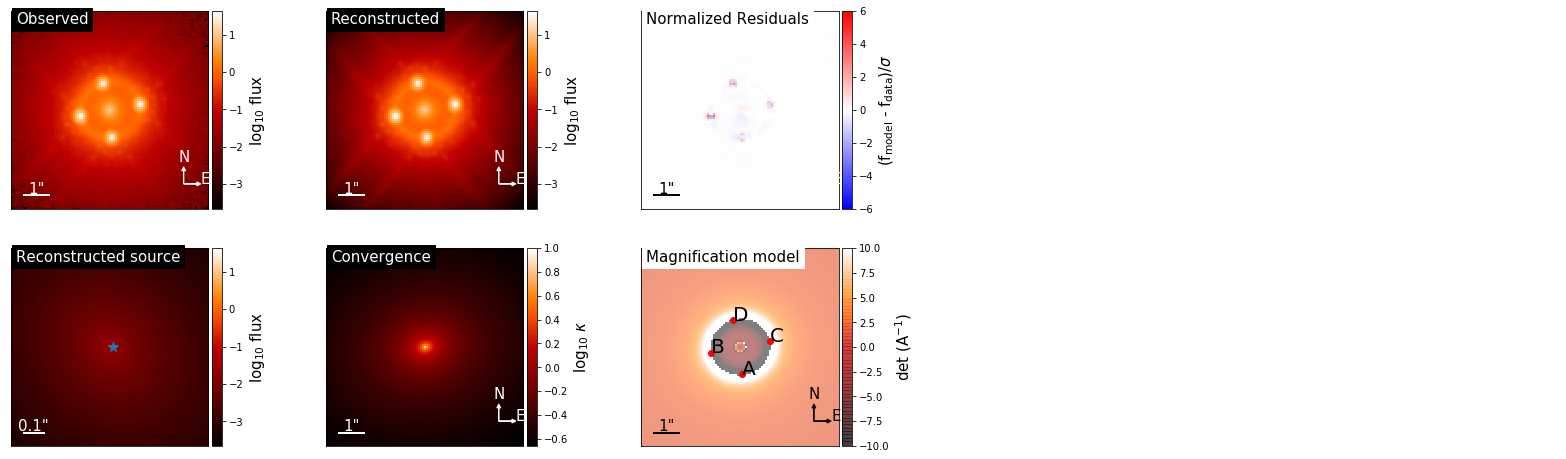

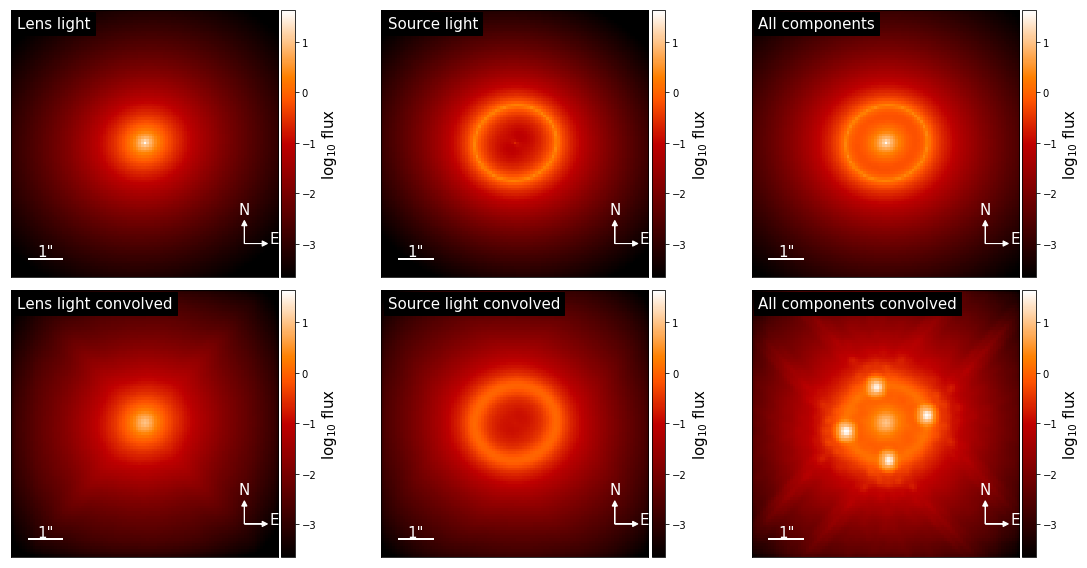

{'kwargs_lens': [{'theta_E': 1.1565394684094177, 'gamma': 1.6797191440718473, 'e1': 0.09387115244765923, 'e2': 0.04511413515843658, 'center_x': 0.01637366613567135, 'center_y': 0.000319410747961966}, {'gamma_ext': 0.08789589137097688, 'psi_ext': 0.22120926393923934, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 17.356284149514238, 'R_sersic': 0.4815341157234907, 'n_sersic': 1.8216915320071347, 'e1': -0.009159688460891227, 'e2': -0.08445576986446576, 'center_x': 0.016483856391582254, 'center_y': -0.00012184071962538512}], 'kwargs_lens_light': [{'amp': 262.9769760936351, 'R_sersic': 0.42577780558579503, 'n_sersic': 2.0884505708760237, 'e1': 0.05242320405001431, 'e2': 0.026095934817970835, 'center_x': 0.003937456221392277, 'center_y': 0.012971869455779087}], 'kwargs_ps': [{'ra_image': array([ 0.08425866, -1.16845731,  1.21078395, -0.27748057]), 'dec_image': array([-1.10008411, -0.24960512,  0.22682766,  1.06046549]), 'point_amp': array([365.97369337, 503.55281226, 416.93945305, 373.6

In [11]:
##### VAMOS A GRAFICAR LO QUE NOS DA 

from lenstronomy.Plots.output_plots import ModelPlot
import lenstronomy.Plots.output_plots as out_plot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

param_class = fitting_seq.param_class
print(param_class.num_param())
#print(chain_list)

for i in range(len(chain_list)):
    out_plot.plot_chain_list(chain_list, i)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
#f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
#plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)